1/1 [==============================] - 0s 204ms/step
(200, 285, 64)


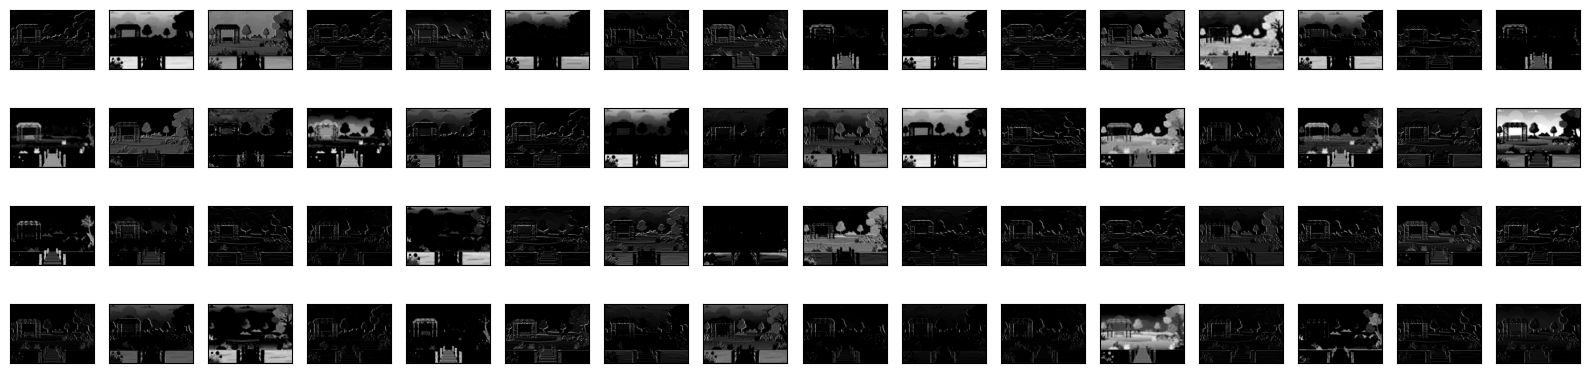

Cost at 0: 19007266816.0. Time elapsed: 47.607402324676514
Cost at 2: 7768046592.0. Time elapsed: 138.65087032318115
Cost at 4: 4117693696.0. Time elapsed: 234.56064009666443
Cost at 6: 2730561024.0. Time elapsed: 325.89077973365784
Cost at 8: 2204848384.0. Time elapsed: 410.11235880851746
Cost at 10: 1974061952.0. Time elapsed: 495.66091084480286
Cost at 12: 1828413312.0. Time elapsed: 583.6901257038116
Cost at 14: 1699900160.0. Time elapsed: 671.3460984230042
Cost at 16: 1573923584.0. Time elapsed: 757.7913720607758
Cost at 18: 1452260480.0. Time elapsed: 844.434561252594


In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float32')  # Set float type for TensorFlow

# Load the pre-trained VGG19 model
model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
model.trainable = False

def load_and_process_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

def deprocess(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, :, -1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image):
    if len(image.shape) == 4:
        img = np.squeeze(image, axis=0)
    img = deprocess(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

content_layer = 'block4_conv2'
content_model = Model(inputs=model.input, outputs=model.get_layer(content_layer).output)

style_layers = ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1']
style_models = [Model(inputs=model.input, outputs=model.get_layer(layer).output) for layer in style_layers]

# Define preprocess_image() function (not shown in your code, but assumed to exist)
def preprocess_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

x = preprocess_image('C://Users//vshar//OneDrive//Desktop//one.jpg')  # You need to define style_image_path
temp_layer = 'block1_conv1'
temp_model = Model(inputs=model.input, outputs=model.get_layer(temp_layer).output)
out = temp_model.predict(x)[0]
print(out.shape)

plt.figure(figsize=(16, 8))
for i in range(0, 64):
    plt.subplot(8, 16, i + 1)
    plt.imshow(out[:, :, i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

lam = 1.0 / len(style_models)

def style_cost(style, generated):
    J_style = 0
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * lam
    return J_style

import time

generated_images = []

def training_loop(content_path, style_path, iterations=20, a=10.0, b=20.0):
    # Initialize
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.Variable(content, dtype=tf.float32)
    opt = tf.optimizers.Adam(learning_rate=7.0)
    best_cost = 1e12 + 0.1
    best_image = None
    start_time = time.time()

    for i in range(iterations):
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = a * J_content + b * J_style
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])

        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
        if i % int(iterations / 10) == 0:
            time_taken = time.time() - start_time
            print('Cost at {}: {}. Time elapsed: {}'.format(i, J_total, time_taken))
            generated_images.append(generated.numpy())
    return best_image

# You need to define content_image_path and style_image_path before calling training_loop()
best_generated_image = training_loop('C://Users//vshar//OneDrive//Desktop//one.jpg', 'C://Users//vshar//OneDrive//Desktop//two.jpg')


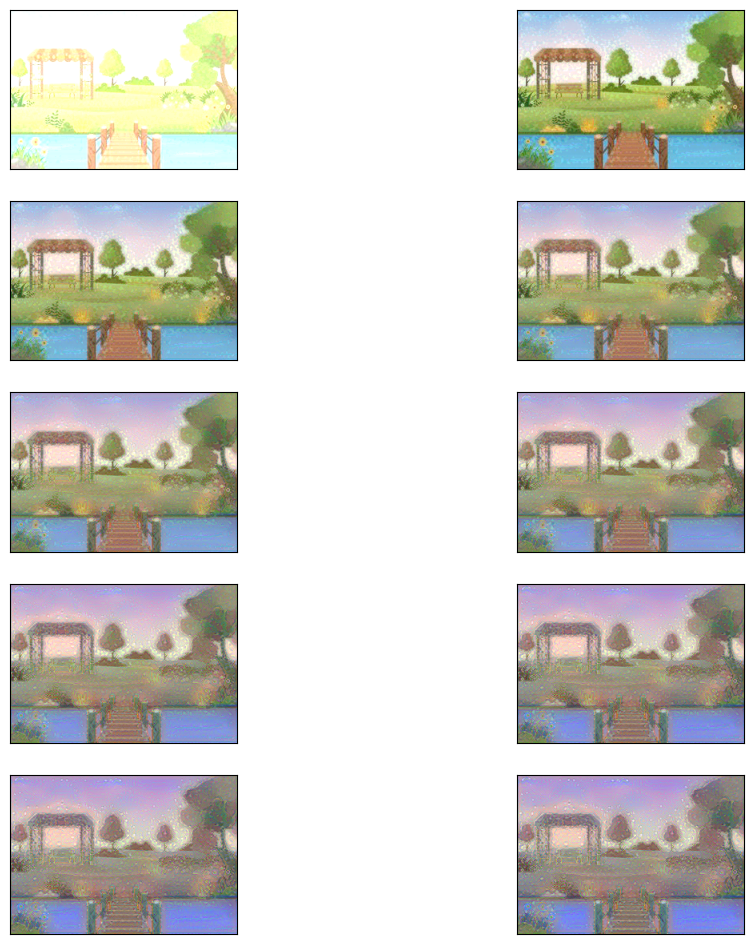

In [26]:
plt.figure(figsize=(12,12))
for i in range(10):
    plt.subplot(5,2,i+1)
    display_image(generated_images[i])
plt.show()

In [25]:
def deprocess(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image):
    if len(image.shape) == 4:
        img = np.squeeze(image, axis=0)
    img = deprocess(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return